<a href="https://colab.research.google.com/github/giyuhwang/waste_classification/blob/main/APS360_Team_3_Waste_Classification_Project_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Team 3 - Waste Classification Project
 
* Team Member: Faisal Hussaini, Insha Worliwalla, Il Gyu(Gil) Hwang


## Link to Github
Github Link: https://github.com/giyuhwang/waste_classification 

## Global Variables & Helper Functions

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import time
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
from IPython.utils import path
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sn
from torchsummary import summary

In [ ]:
# Mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Global Variables

In [ ]:
# Global variables
classes = ['containers_for_recycling', 'garbage', 'organics',
           'paper_coffee_cups', 'paper_for_recycling']
folder_path = '/content/gdrive/MyDrive/APS360 Fall 2022'
use_cuda = True

### Model Helper Functions

In [ ]:
########################################################################
def get_output_size(input, padding, kernel_size, stride):
  """ Compute output size after input passes a CNN layer
      Formula used: o = (i + 2p - k) / (s+1)
  """
  output = int((input + 2 * padding - kernel_size) / stride) + 1
  return output

########################################################################
def get_accuracy(net, loader):
  """ Compute accuracy of model using all dataset in loader
  """
  # Local variables
  correct = 0
  total = 0

  for images, labels in loader:
    # Use GPU accelerator if possible
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # Forward pass
    outputs = net(images)

    # Count number of correct predictions
    pred = outputs.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += images.shape[0]  # Batch size
  
  # Compute average accuracy
  accuracy = correct / total
  return accuracy

########################################################################
def validate(net, loader, criterion):
  """ Evaluate the accuracy and loss of neural network with 
      validation dataset.

      Args:
        net: instance of neural network
        loader: validation dataset loader
        criterion: defined loss function. Should be same as training

      Returns:
        val_accuracy: average accuracy using validation dataset
        val_loss: average loss using validation dataset 
  """
  # Local variables
  total_loss = 0
  total_epoch = 0

  # Calculate average accuracy for validation dataset
  val_accuracy = get_accuracy(net, loader)

  # Calculate average loss for validation dataset
  for i, data in enumerate(loader, 0):
    images, labels = data

    # Use GPU accelerator if possible
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    outputs = net(images)
    loss = criterion(outputs, labels)
    total_loss += loss.item()

  val_loss = float(total_loss) / (i+1)

  return val_accuracy, val_loss

########################################################################
def print_acc_loss(epoch, num_epoch, train_acc, train_loss, val_acc, val_loss):
  """ Print report of accuracy and loss of model
  """
  print(('>> Epoch [{}/{}]: Train Accuracy: {:.4f}, Train Loss: {:.4f} | '
          'Validation Accuracy: {:.4f}, Validation Loss: {:4f}').format(
              epoch + 1,
              num_epoch,
              train_acc,
              train_loss,
              val_acc,
              val_loss))
  
########################################################################
def get_model_path(name, batch_size, lr, epoch):
  """ Get the path in google drive for a given model

      Args:
        name: name of the neural network (self.name)
        batch_size: size of batch
        lr: learning rate
        epoch: current or last number of epoch
  """
  sub_folder_path = ('Hyperparameter Search/Gil/Model')
  path = ('model_{0}_bs{1}_lr{2}_epoch{3}'.format(name,
                                                   batch_size,
                                                   lr,
                                                   epoch))
  return os.path.join(folder_path, sub_folder_path, path)

########################################################################
def plot_training_curve(path):
  """ Plot training and validation accuracy/loss given a csv file path

      Args:
        path: path of folder that contains csv files for accuracy/loss
  """
  # Retrieve data from csv files
  train_acc = np.loadtxt('{}_train_accuracy.csv'.format(path))
  val_acc = np.loadtxt('{}_validation_accuracy.csv'.format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_validation_loss.csv".format(path))

  plt.title("Train vs Validation Accuracy")
  n = len(train_acc) # number of epochs
  plt.plot(range(1,n+1), train_acc, label="Train")
  plt.plot(range(1,n+1), val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def train_net(net, batch_size = 64, lr = 0.001, num_epochs = 30, weight_decay=0):
  """ Train the model with training and validation dataset

      Args:
        net: instance of neural network
        batch_size: size of batch
        lr: learning rate
        num_epoch: total number of epochs
  """
  # Set fixed seed value for reproducable results
  torch.manual_seed(1000)

  #######################################################################
  # Retrieve train and validation datasets
  train_loader, val_loader, test_loader = get_data_loader(batch_size)

  #######################################################################
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  #optimizer = optim.Adam(net.parameters(), lr = lr)
  optimizer = optim.AdamW(net.parameters(), lr = lr, weight_decay=weight_decay)

  #######################################################################
  # Local variables
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  max_val_acc = 0

  #######################################################################
  # Train neural network
  
  # Initial setup
  start_time = time.time()
  print('===== Training Started ======')

  for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_acc = 0

    # Iterate each batch of images
    for i, data in enumerate(train_loader, 0):
      # Retrieve inputs
      images, labels = data

      # Use GPU Accelerator if possible
      if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

      # Forward pass
      optimizer.zero_grad()   # Reset gradient
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Track accumulated total loss
      total_train_loss += loss.item()

    # Compute average accuracy and loss for each epoch
    train_acc[epoch] = get_accuracy(net, train_loader)
    train_loss[epoch] = float(total_train_loss) / (i + 1)
    val_acc[epoch], val_loss[epoch] = validate(net, val_loader, criterion)

    # Report accuracy and loss results
    print_acc_loss(epoch, num_epochs, train_acc[epoch], train_loss[epoch],
                   val_acc[epoch], val_loss[epoch])
    
    # Keep track of model with best validation accuracy
    if val_acc[epoch] >= max_val_acc:
      best_model = net.state_dict()
      best_epoch = epoch
      max_val_acc = val_acc[epoch]

  # Save model checkpoint for best validation accuracy
  model_path = get_model_path(net.name, batch_size, lr, best_epoch)
  torch.save(best_model, model_path)
  
  # Report total training time
  end_time = time.time()
  train_time = end_time - start_time
  print('===== Training Finished =====')
  print('===== Total train time: [{:.2f}s] ====='.format(train_time))

  # Save accuracy/loss results in csv files
  np.savetxt('{}_train_accuracy.csv'.format(model_path), train_acc)
  np.savetxt('{}_train_loss.csv'.format(model_path), train_loss)
  np.savetxt('{}_validation_accuracy.csv'.format(model_path), val_acc)
  np.savetxt('{}_validation_loss.csv'.format(model_path), val_loss)

### Dataset Helper Functions

In [ ]:
def get_data_loader(batch_size, num_workers = 0):
  """ Retrieve image dataset as dataloaders

      Args:
        batch_size: number of image samples per batch
        num_workers: number of sub-processes used for data loading
                     Default value is 0.

      Return:
        train_loader: iterable training dataset
        val_loader: iterable validation dataset
        test_loader: iterable testing dataset
  """
  # Get folder paths for train, validation, test dataset
  data_path = os.path.join(folder_path, 'Data')
  train_path = os.path.join(folder_path, 'Data_with_Aug_new')
  #train_path = os.path.join(data_aug_path, 'Training')
  val_path = os.path.join(data_path, 'Validation')
  test_path = os.path.join(data_path, 'Testing')

  # Retrieve dataset from each folder
  transform = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor()])
  train_data = datasets.ImageFolder(train_path, transform = transform)
  print(train_data.class_to_idx)
  val_data = datasets.ImageFolder(val_path, transform = transform)
  test_data = datasets.ImageFolder(test_path, transform = transform)
  
  # Construct data loaders based on retrieved dataset
  train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                             batch_size = batch_size,
                                             num_workers = num_workers, 
                                             shuffle = True)
  val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers, 
                                           shuffle = True)
  test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                            batch_size = batch_size,
                                            num_workers = num_workers, 
                                            shuffle = True)
  
  return train_loader, val_loader, test_loader

###############################################################
def get_confusion_matrix(model, loader):
  """ Compute and display confusion matrix
      Code Reference: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
  
      Return:
        df_confusion: pandas dataframe of calculated confusion matrix
        score_f1: calculated f1 score based on confusion matrix
  """
  # Local variables
  pred = []
  actual = []

  for images, labels in test_loader:
    # Use GPU Accelerator if possible
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # Forward pass & get prediction
    prediction = model(images)

    # Apply softmax for probability 0 to 1
    prediction = F.softmax(prediction, dim = 1)

    # Track prediction and actual label
    prediction = torch.max(prediction, 1)[1].data.cpu().numpy()
    pred.extend(prediction)
    labels = labels.data.cpu().numpy()
    actual.extend(labels)
  
  # Construct confusion matrix
  cf_matrix = confusion_matrix(actual, pred)
  df_confusion = pd.DataFrame(cf_matrix, 
                            index = [i for i in classes],
                            columns = [i for i in classes])
  
  # Calculate f1 score
  score_f1 = f1_score(actual, pred, average = None)
  
  return df_confusion, score_f1

###############################################################
def show_confusion_matrix(df_confusion):
  """ Visualize confusion matrix as heatmap
  """
  plt.figure(figsize = (12,7))
  sn.heatmap(df_confusion, annot = True)
  

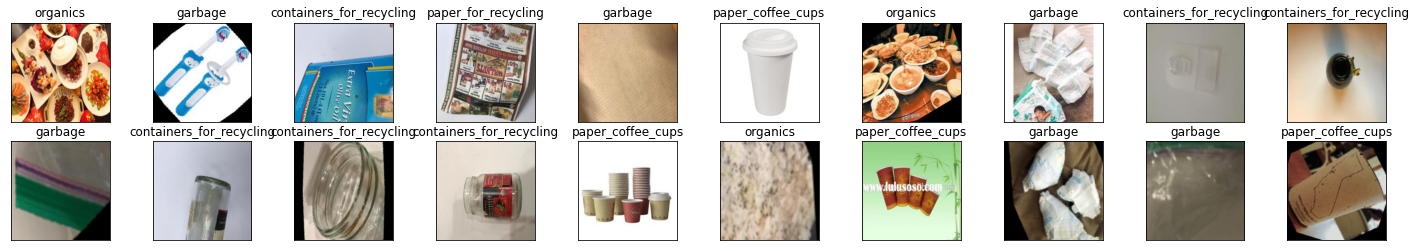

In [ ]:
#########################################################
# Visualize few sample images
train_loader, _, _ = get_data_loader(64)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Primary Model

### Neural Network Definition

In [ ]:
class WasteNet(nn.Module):
  """ Neural network of primary model
  """
  def __init__(self, input_size, kernel_size):
      """ Constructor of primary model

          Args:
            input_size: dimension of input image size, assuming square dimension
            kernel_size: dimension of all kernel sizes within network, assuming
                          square dimension
      """
      super(WasteNet, self).__init__()
      self.name = 'WasteNet'

      # Output size
      num_classes = len(classes)
      self.linear_size = 2048
      fc1_size = 64
      fc2_size = 32

      # Neural network with pretrained weights
      self.pretrained_net = models.resnet152(pretrained = True)

      # Freeze the weights
      for param in self.pretrained_net.parameters():
        param.requires_grad = False

      self.pretrained_layers = list(self.pretrained_net._modules.keys())

      # Remove the last classifier of pretrained model
      self.pretrained_net._modules.pop(self.pretrained_layers[-1])

      # Construct feature extractor
      self.feature_extractor = nn.Sequential(self.pretrained_net._modules)
      
      # Model layers
      self.fc1 = nn.Linear(self.linear_size, fc1_size)
      self.fc2 = nn.Linear(fc1_size, fc2_size)
      self.classifier = nn.Linear(fc2_size, num_classes)
      self.dropout1 = nn.Dropout(0.4)


  def forward(self, input):
      x = self.feature_extractor(input)
      x = x.view(-1, self.linear_size)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout1(x)
      x = self.fc2(x)
      x = F.relu(x)
      output = self.classifier(x)
      return output

class WasteNet2(nn.Module):
  """ Neural network of primary model
  """
  def __init__(self, input_size, kernel_size):
      """ Constructor of primary model

          Args:
            input_size: dimension of input image size, assuming square dimension
            kernel_size: dimension of all kernel sizes within network, assuming
                          square dimension
      """
      super(WasteNet2, self).__init__()
      self.name = 'WasteNet'

      # Output size
      num_classes = len(classes)
      self.linear_size = 2048
      fc1_size = 64
      fc2_size = 32
      fc3_size = 16

      # Neural network with pretrained weights
      self.pretrained_net = models.resnet152(pretrained = True)

      # Freeze the weights
      for param in self.pretrained_net.parameters():
        param.requires_grad = False

      self.pretrained_layers = list(self.pretrained_net._modules.keys())

      # Remove the last classifier of pretrained model
      self.pretrained_net._modules.pop(self.pretrained_layers[-1])

      # Construct feature extractor
      self.feature_extractor = nn.Sequential(self.pretrained_net._modules)
      
      # Model layers
      self.fc1 = nn.Linear(self.linear_size, fc1_size)
      self.fc2 = nn.Linear(fc1_size, fc2_size)
      self.fc3 = nn.Linear(fc2_size, fc3_size)
      self.classifier = nn.Linear(fc3_size, num_classes)
      self.dropout1 = nn.Dropout(0.4)
      self.dropout2 = nn.Dropout(0.4)


  def forward(self, input):
      x = self.feature_extractor(input)
      x = x.view(-1, self.linear_size)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout1(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc3(x)
      x = F.relu(x)
      output = self.classifier(x)
      return output

In [ ]:
# Visualize the pretrained model architecture
pretrained_model = models.resnet152(pretrained = True)
from torchsummary import summary
summary(pretrained_model.cuda(), input_size = (3, 224, 224))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Training

### Hyperparameter 1

In [ ]:
# Create instance of model
primary_net = WasteNet(input_size = 224, kernel_size = 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  primary_net.cuda()

train_net(primary_net, batch_size = 256, lr = 0.00025, num_epochs = 30, weight_decay = 0.01)

===== Training Started ======


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


>> Epoch [1/30]: Train Accuracy: 0.5333, Train Loss: 1.5606 | Validation Accuracy: 0.5333, Validation Loss: 1.491853
>> Epoch [2/30]: Train Accuracy: 0.5695, Train Loss: 1.4363 | Validation Accuracy: 0.6000, Validation Loss: 1.337632
>> Epoch [3/30]: Train Accuracy: 0.6310, Train Loss: 1.3180 | Validation Accuracy: 0.7033, Validation Loss: 1.264096
>> Epoch [4/30]: Train Accuracy: 0.6729, Train Loss: 1.2013 | Validation Accuracy: 0.6900, Validation Loss: 1.129135
>> Epoch [5/30]: Train Accuracy: 0.7162, Train Loss: 1.0688 | Validation Accuracy: 0.7367, Validation Loss: 1.062741
>> Epoch [6/30]: Train Accuracy: 0.7281, Train Loss: 0.9758 | Validation Accuracy: 0.7800, Validation Loss: 0.959958
>> Epoch [7/30]: Train Accuracy: 0.7700, Train Loss: 0.8793 | Validation Accuracy: 0.7833, Validation Loss: 0.874121
>> Epoch [8/30]: Train Accuracy: 0.7724, Train Loss: 0.7893 | Validation Accuracy: 0.7700, Validation Loss: 0.730668
>> Epoch [9/30]: Train Accuracy: 0.7914, Train Loss: 0.7405 | Va

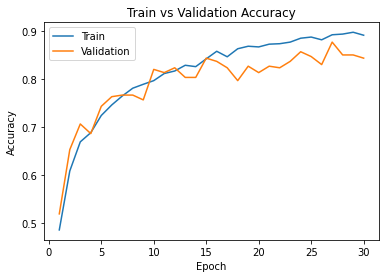

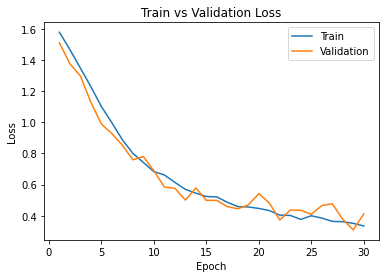

In [ ]:
# Plot training/validation curves
model1_path = get_model_path(primary_net.name, batch_size = 256, lr = 0.00025, epoch = 26)
plot_training_curve(model1_path)

### Testing

In [ ]:
# Create new instance of model for testing
model1_test = WasteNet(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model1_test.cuda()

# Retrieve the best model
best_model1_path = get_model_path(model1_test.name, batch_size = 256, lr = 0.00025, epoch = 26)
model1_best_state = torch.load(best_model1_path)
model1_test.load_state_dict(model1_best_state)

# Get testing dataset
_, _, test_loader = get_data_loader(32)

# Test model
primary_test_accuracy = get_accuracy(model1_test, test_loader)
print('Test accuracy of model 1 is {:.4f} %'.format(
                                                    primary_test_accuracy*100))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: ignored

In [ ]:
# Compute confusion matrix
df_cfmatrix, f1_score_primary = get_confusion_matrix(model1_test, test_loader)

# Display confusion matrix and f1 score
show_confusion_matrix(df_cfmatrix)

print('=== F1 score of model prediction ===')
for i in range(0, len(classes)):
  print('Class [{}]: {:.4f}'.format(classes[i], f1_score_primary[i]))





#Demonstration 




In [ ]:
# Create new instance of model for testing
model_demo = WasteNet(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model_demo.cuda()

# Retrieve the best model
demo_model_path = get_model_path(model_demo.name, batch_size = 256, lr = 0.00025, epoch = 26)
demo_model_best_state = torch.load(demo_model_path)
model_demo.load_state_dict(demo_model_best_state)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

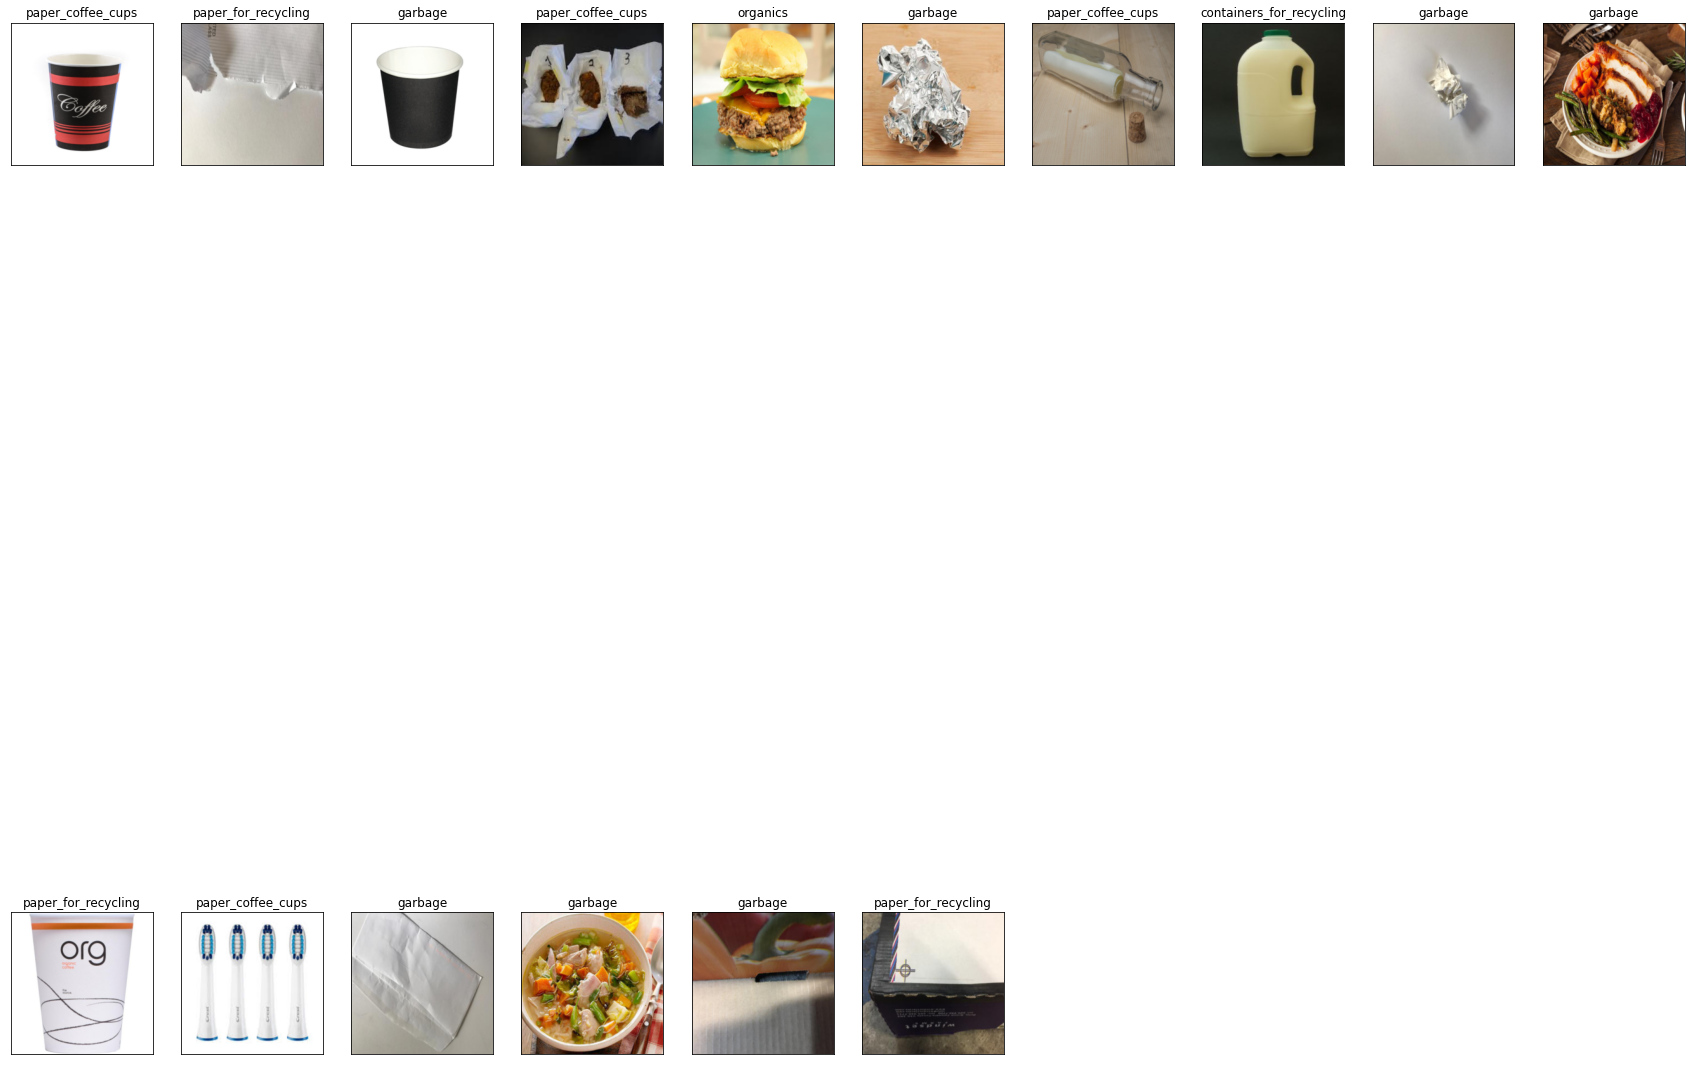

In [ ]:
torch.manual_seed(130)
path = os.path.join(folder_path, 'Demo_picture')
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])
one_image_data = datasets.ImageFolder(path, transform = transform)
one_image_loader = torch.utils.data.DataLoader(dataset = one_image_data, 
                                            batch_size = 1,
                                            num_workers = 1, 
                                            shuffle = True)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 30))
idx = 0
for img, label in one_image_loader:
  pred = model_demo(img.cuda())
  pred_class = torch.argmax(pred)
  img_numpy = img.numpy() # convert images to numpy for display
  
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(img[0], (1, 2, 0)))
  ax.set_title(classes[pred_class])
  idx += 1












.

.

.

## Hyperparameter 2

In [ ]:
# Create instance of model
model2 = WasteNet(input_size = 224, kernel_size = 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model2.cuda()

train_net(model2, batch_size = 256, lr = 0.001, num_epochs = 30, weight_decay = 0.01)

In [ ]:
# Plot training/validation curves
model2_path = get_model_path(primary_net.name, batch_size = 256, lr = 0.001, epoch = 26)
plot_training_curve(model2_path)

In [ ]:
# Create new instance of model for testing
model2_test = WasteNet(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model2_test.cuda()

# Retrieve the best model
best_model2_path = get_model_path(model2_test.name, batch_size = 256, lr = 0.001, epoch = 26)
model2_best_state = torch.load(best_model2_path)
model2_test.load_state_dict(model2_best_state)

# Get testing dataset
_, _, test_loader = get_data_loader(256)

# Test model
model4_test_accuracy = get_accuracy(model2_test, test_loader)
print('Test accuracy of model 2 is {:.4f} %'.format(
                                                    model4_test_accuracy*100))

In [ ]:
# Compute confusion matrix
df_cfmatrix, f1_score_primary = get_confusion_matrix(model2_test, test_loader)

# Display confusion matrix and f1 score
show_confusion_matrix(df_cfmatrix)

print('=== F1 score of model prediction ===')
for i in range(0, len(classes)):
  print('Class [{}]: {:.4f}'.format(classes[i], f1_score_primary[i]))

## Hyperparameter 3

In [ ]:
# Create instance of model
model3 = WasteNet2(input_size = 224, kernel_size = 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model3.cuda()

train_net(model3, batch_size = 64, lr = 0.0001, num_epochs = 30, weight_decay = 0.01)

In [ ]:
# Plot training/validation curves
model3_path = get_model_path(model3.name, batch_size = 64, lr = 0.0001, epoch = 24)
plot_training_curve(model3_path)

In [ ]:
# Create new instance of model for testing
model3_test = WasteNet2(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model3_test.cuda()

# Retrieve the best model
best_model2_path = get_model_path(model3_test.name, batch_size = 64, lr = 0.0001, epoch = 24)
model3_best_state = torch.load(best_model2_path)
model3_test.load_state_dict(model3_best_state)

# Get testing dataset
_, _, test_loader = get_data_loader(64)

# Test model
model3_test_accuracy = get_accuracy(model3_test, test_loader)
print('Test accuracy of model 2 is {:.4f} %'.format(
                                                    model3_test_accuracy*100))

In [ ]:
# Compute confusion matrix
df_cfmatrix, f1_score_primary = get_confusion_matrix(model3_test, test_loader)

# Display confusion matrix and f1 score
show_confusion_matrix(df_cfmatrix)

print('=== F1 score of model prediction ===')
for i in range(0, len(classes)):
  print('Class [{}]: {:.4f}'.format(classes[i], f1_score_primary[i]))

## Hyperparameter 4

In [ ]:
# Create instance of model
model4 = WasteNet(input_size = 224, kernel_size = 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model4.cuda()

train_net(model4, batch_size = 256, lr = 0.0005, num_epochs = 30, weight_decay = 0.01)

In [ ]:
# Plot training/validation curves
model4_path = get_model_path(model4.name, batch_size = 256, lr = 0.0005, epoch = 29)
plot_training_curve(model4_path)

In [ ]:
# Create new instance of model for testing
model4_test = WasteNet(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model4_test.cuda()

# Retrieve the best model
best_model4_path = get_model_path(model4_test.name, batch_size = 256, lr = 0.0005, epoch = 29)
model4_best_state = torch.load(best_model4_path)
model4_test.load_state_dict(model4_best_state)

# Get testing dataset
_, _, test_loader = get_data_loader(64)

# Test model
model4_test_accuracy = get_accuracy(model4_test, test_loader)
print('Test accuracy of model 2 is {:.4f} %'.format(
                                                    model4_test_accuracy*100))

In [ ]:
# Compute confusion matrix
df_cfmatrix, f1_score_primary = get_confusion_matrix(model4_test, test_loader)

# Display confusion matrix and f1 score
show_confusion_matrix(df_cfmatrix)

print('=== F1 score of model prediction ===')
for i in range(0, len(classes)):
  print('Class [{}]: {:.4f}'.format(classes[i], f1_score_primary[i]))

## Hyperparameter 5

In [ ]:
# Create instance of model
model5 = WasteNet(input_size = 224, kernel_size = 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model5.cuda()

train_net(model5, batch_size = 256, lr = 0.00075, num_epochs = 30, weight_decay = 0.01)

In [ ]:
# Plot training/validation curves
model5_path = get_model_path(model5.name, batch_size = 256, lr = 0.00075, epoch = 26)
plot_training_curve(model5_path)

In [ ]:
# Create new instance of model for testing
model5_test = WasteNet(224, 3)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  model5_test.cuda()

# Retrieve the best model
best_model5_path = get_model_path(model5_test.name, batch_size = 256, lr = 0.00075, epoch = 26)
model5_best_state = torch.load(best_model5_path)
model5_test.load_state_dict(model5_best_state)

# Get testing dataset
_, _, test_loader = get_data_loader(64)

# Test model
model5_test_accuracy = get_accuracy(model5_test, test_loader)
print('Test accuracy of model 2 is {:.4f} %'.format(
                                                    model5_test_accuracy*100))

In [ ]:
# Compute confusion matrix
df_cfmatrix, f1_score_primary = get_confusion_matrix(model5_test, test_loader)

# Display confusion matrix and f1 score
show_confusion_matrix(df_cfmatrix)

print('=== F1 score of model prediction ===')
for i in range(0, len(classes)):
  print('Class [{}]: {:.4f}'.format(classes[i], f1_score_primary[i]))